In [1]:
#khai báo thư viện
import pandas as pd #đọc dữ liệu
import datetime as dt #lấy ngày tháng
import matplotlib.pyplot as plt #vẽ biểu đồ
import numpy as np #xử lí dữ liệu
import os #dự liệu hệ thống
import plotly.express as px #vẽ biểu đồ
import seaborn as sns #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện
from tensorflow.keras.models import load_model #tải model

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #Đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số trung bình

In [449]:
#đọc dữ liệu
path = ('C:\Python\Data\CRYPTO\BNB_coin')
df = pd.read_csv(path +'\Dữ liệu Lịch sử BNB.csv')
df

,Ngày,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi
0,09/11/2017,1.99,1.99,2.20,1.90,283.35K,0.00%
1,10/11/2017,1.71,1.99,2.02,1.60,483.23K,-14.07%
2,11/11/2017,1.66,1.71,1.93,1.58,256.71K,-2.92%
3,12/11/2017,1.49,1.66,1.70,1.34,456.48K,-10.24%
4,13/11/2017,1.68,1.49,1.74,1.49,166.01K,12.75%
...,...,...,...,...,...,...,...
1804,18/10/2022,273.19,275.70,276.00,270.21,206.23K,-0.91%
1805,19/10/2022,272.10,273.19,273.79,270.40,161.82K,-0.40%
1806,20/10/2022,269.00,272.09,273.30,267.69,176.43K,-1.14%
1807,21/10/2022,270.00,269.00,271.00,263.90,208.64K,0.37%


In [450]:
df1=df.reset_index()['Lần cuối']
df1.shape

(1809,)

In [451]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1

array([[7.40663931e-04],
       [3.25892130e-04],
       [2.51825737e-04],
       ...,
       [3.96270016e-01],
       [3.97751344e-01],
       [3.97455079e-01]])

In [452]:
train_size =int(len(df1)*0.8)
test_size=len(df1)-train_size
train_data,test_data=df1[0:train_size,:],df1[train_size:len(df1):1]

In [453]:
print(train_data.shape)
print(test_data.shape)

(1447, 1)
(362, 1)


In [454]:
def create_dataset(dataset,time_step=1):
    dataX,dataY=[],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:i+time_step,0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX),np.array(dataY)

In [455]:
time_step=100
X_train,Y_train=create_dataset(train_data,time_step)
X_test,Y_test=create_dataset(test_data,time_step)

In [456]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1346, 100) (1346,)
(261, 100) (261,)


In [457]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [458]:
#xây dựng mô hình
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_absolute_error',optimizer='adam')

In [459]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_25 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_26 (LSTM)              (None, 50)                20200     
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [460]:
save_model="save_model.hdf5"
best_model=ModelCheckpoint(save_model,monitor='loss',verbose=1,save_best_only=True,mode='auto')
model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10,batch_size=64,verbose=1,callbacks=[best_model])


Epoch 1/10
22/22 [==============================] - ETA: 0s - loss: 0.0426
Epoch 1: loss improved from inf to 0.04258, saving model to save_model.hdf5
22/22 [==============================] - 11s 239ms/step - loss: 0.0426 - val_loss: 0.1283
Epoch 2/10
22/22 [==============================] - ETA: 0s - loss: 0.0239
Epoch 2: loss improved from 0.04258 to 0.02389, saving model to save_model.hdf5
22/22 [==============================] - 4s 180ms/step - loss: 0.0239 - val_loss: 0.0533
Epoch 3/10
22/22 [==============================] - ETA: 0s - loss: 0.0194
Epoch 3: loss improved from 0.02389 to 0.01937, saving model to save_model.hdf5
22/22 [==============================] - 4s 176ms/step - loss: 0.0194 - val_loss: 0.0301
Epoch 4/10
22/22 [==============================] - ETA: 0s - loss: 0.0160
Epoch 4: loss improved from 0.01937 to 0.01598, saving model to save_model.hdf5
22/22 [==============================] - 4s 175ms/step - loss: 0.0160 - val_loss: 0.0952
Epoch 5/10
22/22 [=========

In [461]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

9/9 [==============================] - 0s 37ms/step


In [462]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [463]:
import math
from sklearn.metrics import mean_squared_error

print("RMSE",math.sqrt(mean_squared_error(Y_train,train_predict)))

RMSE 159.15184573643108


In [464]:
print("RMSE",math.sqrt(mean_squared_error(Y_test,test_predict)))

RMSE 313.8797947323158


In [465]:
lock_back=100
train_predict_plot=np.empty_like(df1)
train_predict_plot[:,:]=np.nan
train_predict_plot[lock_back:len(train_predict)+lock_back,:]=train_predict

test_predict_plot=np.empty_like(df1)
test_predict_plot[:,:]=np.nan
test_predict_plot[len(train_predict)+(lock_back*2)+1:len(df1)-1,:]=test_predict

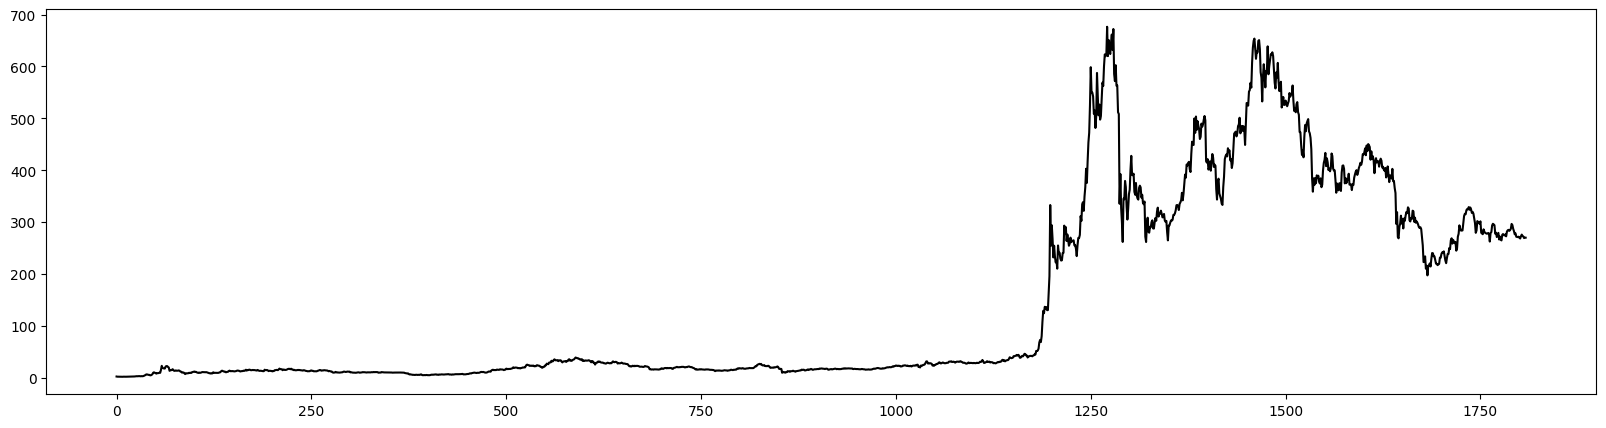

In [466]:
#Lập biểu đồ so sánh
import plotly.express as px

plt.subplots(figsize=(20,5))
plt.plot(scaler.inverse_transform(df1),color='black')
plt.show()


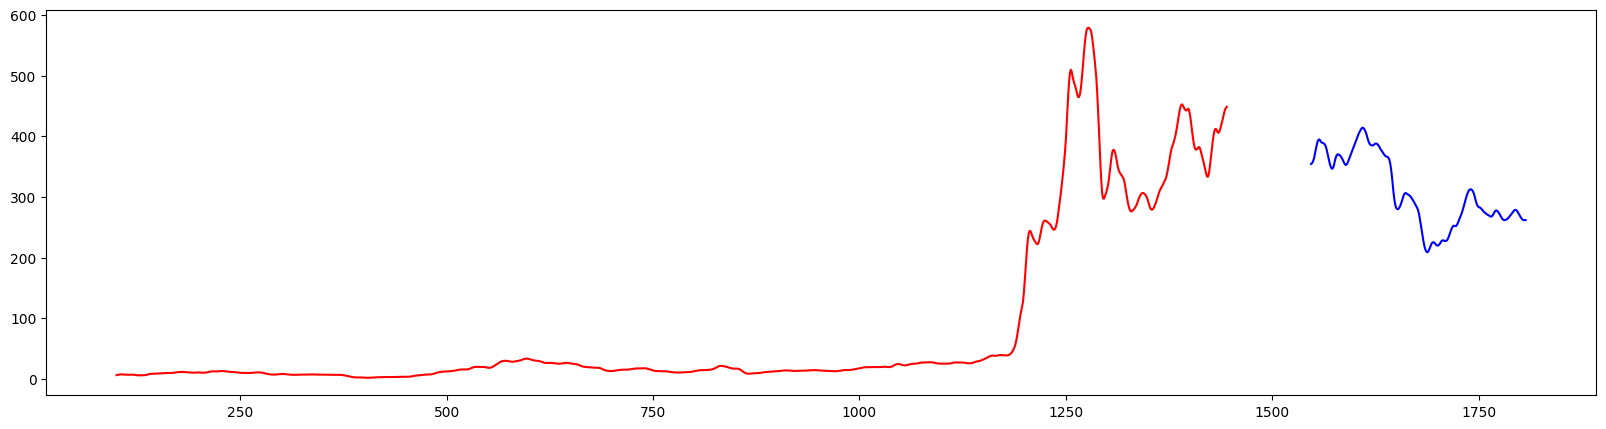

In [467]:
plt.subplots(figsize=(20,5))
plt.plot(train_predict_plot,color='red')
plt.plot(test_predict_plot,color='blue')
plt.show()


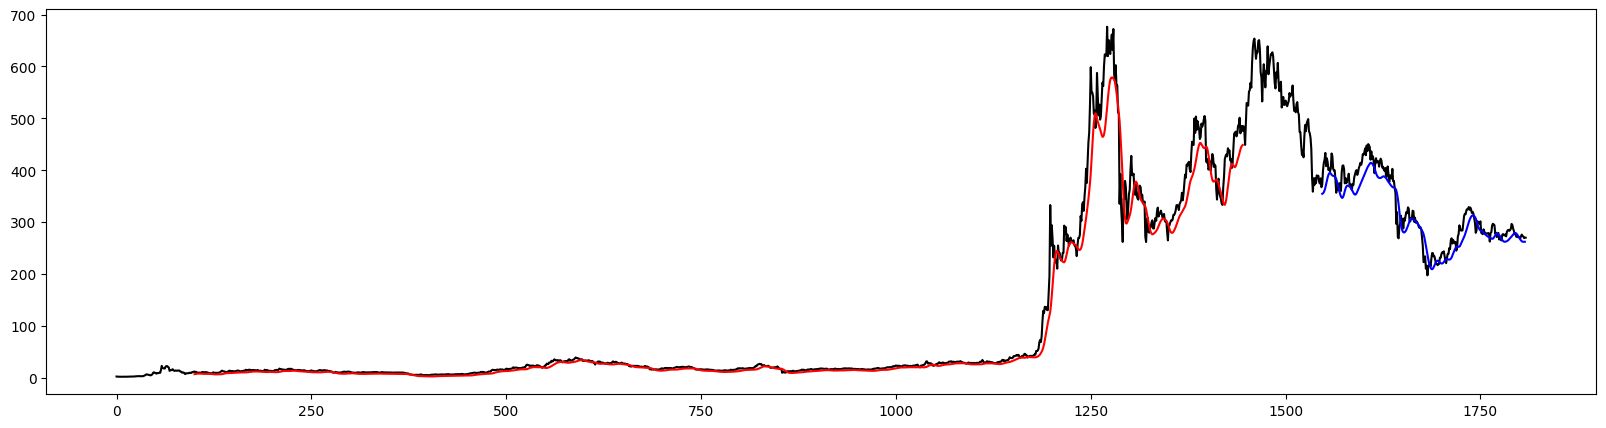

In [468]:
plt.subplots(figsize=(20,5))
plt.plot(scaler.inverse_transform(df1),color='black')
plt.plot(train_predict_plot,color='red')
plt.plot(test_predict_plot,color='blue')
plt.show()


In [469]:
len(test_data)

362

In [470]:
#dự đoán giá trong tương lai
x_input=test_data[262:].reshape(1,-1)
x_input

array([[0.35094138, 0.36781371, 0.36486587, 0.38975217, 0.39567749,
        0.38041981, 0.39108537, 0.3862118 , 0.381753  , 0.38516006,
        0.36027375, 0.36708786, 0.40012147, 0.4084169 , 0.4327255 ,
        0.42397085, 0.41774927, 0.41773446, 0.41819367, 0.43848786,
        0.45922645, 0.46574429, 0.46442591, 0.47596546, 0.47922438,
        0.47833558, 0.48485342, 0.47715052, 0.48366836, 0.47789118,
        0.46812923, 0.47107707, 0.46605537, 0.45241234, 0.43924334,
        0.41126105, 0.41819367, 0.44472425, 0.44248745, 0.4408728 ,
        0.4368584 , 0.44411691, 0.41140919, 0.4093057 , 0.40736516,
        0.42130446, 0.41478661, 0.41124624, 0.41006118, 0.4088613 ,
        0.4093057 , 0.41094998, 0.40769105, 0.38634512, 0.41080184,
        0.41330529, 0.43241442, 0.43716948, 0.43537707, 0.43302176,
        0.40871317, 0.41167583, 0.39923267, 0.40500985, 0.41121661,
        0.39213711, 0.400714  , 0.39213711, 0.38958923, 0.40560238,
        0.40782437, 0.40456545, 0.4038396 , 0.40

In [471]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
print(temp_input)

[0.35094138385648904, 0.3678137082080377, 0.3648658657620692, 0.38975217384863803, 0.39567748529782104, 0.3804198083161747, 0.3910853689247042, 0.3862118002577511, 0.38175300339224083, 0.3851600574755211, 0.3602737493889523, 0.3670878575555128, 0.40012146888470834, 0.4084169049135646, 0.43272549513383807, 0.42397084746767005, 0.4177492704460279, 0.4177344571674049, 0.41819366880471665, 0.43848786051816857, 0.45922645059030925, 0.4657442931844106, 0.4644259113869673, 0.47596545543425134, 0.479224376731302, 0.4783355800139245, 0.48485342260802594, 0.477150517724088, 0.4836683603181893, 0.47789118165523586, 0.46812923104270676, 0.47107707348867534, 0.4660553720354927, 0.45241234242374867, 0.4392433377279394, 0.41126105440917243, 0.41819366880471665, 0.4447242508184337, 0.4424874457463671, 0.44087279837646476, 0.4368583998696432, 0.4441169063948925, 0.4114091871954021, 0.40930570163094204, 0.4073651621313346, 0.4213044573155377, 0.41478661472143635, 0.41124624113054953, 0.4100611788407129,

In [472]:
#dự đoán cho 30 ngày
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    if(len(temp_input)>100):
        #print temp_input
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input=x_input.reshape(1,n_steps,1)
        #print(x_input)
        y_input=model.predict(x_input,verbose=0)
        y_input=scaler.inverse_transform(y_input)
        print("{} day output {}".format(i,y_input))
        temp_input.extend(y_input[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(y_input.tolist())
        i=i+1
    else:
        x_input=x_input.reshape((1,n_steps,1))
        y_input=model.predict(x_input,verbose=0)
        y_input=scaler.inverse_transform(y_input)
        print(y_input[0])
        temp_input.extend(y_input[0].tolist())
        print(len(temp_input))
        lst_output.extend(y_input.tolist())
        i=i+1
   
print(lst_output)


[262.11777]
101
1 day input [  0.36781371   0.36486587   0.38975217   0.39567749   0.38041981
   0.39108537   0.3862118    0.381753     0.38516006   0.36027375
   0.36708786   0.40012147   0.4084169    0.4327255    0.42397085
   0.41774927   0.41773446   0.41819367   0.43848786   0.45922645
   0.46574429   0.46442591   0.47596546   0.47922438   0.47833558
   0.48485342   0.47715052   0.48366836   0.47789118   0.46812923
   0.47107707   0.46605537   0.45241234   0.43924334   0.41126105
   0.41819367   0.44472425   0.44248745   0.4408728    0.4368584
   0.44411691   0.41140919   0.4093057    0.40736516   0.42130446
   0.41478661   0.41124624   0.41006118   0.4088613    0.4093057
   0.41094998   0.40769105   0.38634512   0.41080184   0.41330529
   0.43241442   0.43716948   0.43537707   0.43302176   0.40871317
   0.41167583   0.39923267   0.40500985   0.41121661   0.39213711
   0.400714     0.39213711   0.38958923   0.40560238   0.40782437
   0.40456545   0.4038396    0.40680226   0.401306

In [473]:
day_new=np.arange(1,101)
day_predict=np.arange(101,131)

In [474]:
df3=df1.tolist()
df3.extend(lst_output)

In [475]:
len(df1)

1809

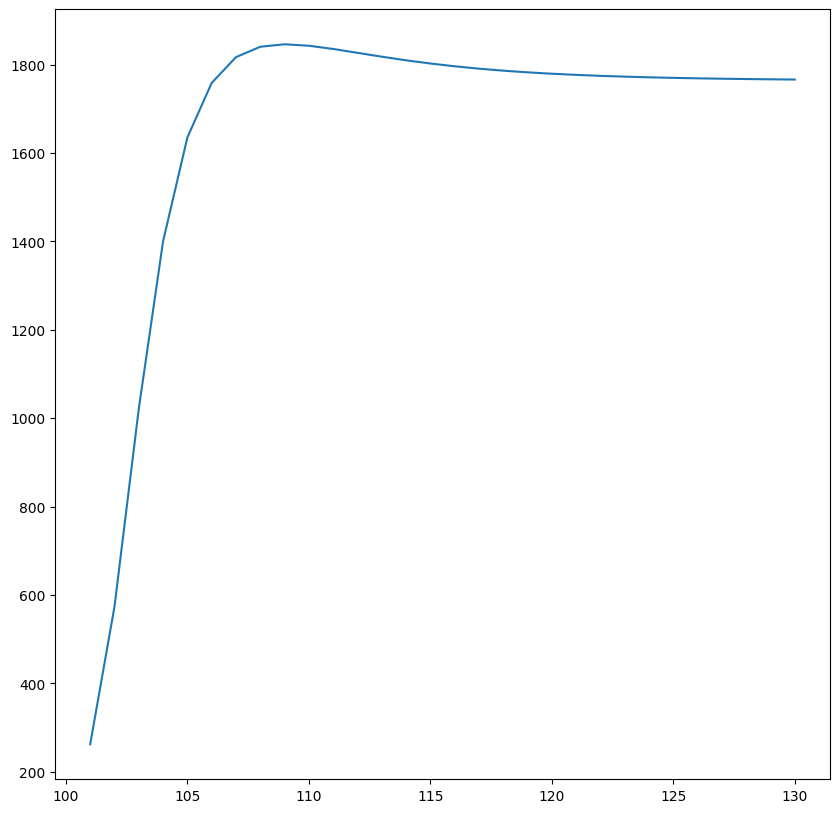

In [489]:
plt.subplots(figsize=(10,10))

plt.plot(day_predict,(lst_output))
plt.show()


In [477]:

px.line(df3[1800:])


In [478]:
len(df3)

1839

In [479]:
df3=scaler.inverse_transform(df3).tolist()
px.line(df3[1800:])